# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [2]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
from itertools import product

import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('./src/SurrogateModeling')
sys.path.append('./src/InverseProblems')
sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *
from model import Model

2024-07-29 09:55:52.122832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [3]:
sample = 16 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [4]:
noise = 0.001

#### Load Surrogate Models

In [5]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

In [6]:
# Initialize the neural network model
model_c = Sequential()

# Add layers to the model
model_c.add(Dense(128, input_shape=(64,), activation='gelu'))
model_c.add(Dense(32, activation='gelu'))
model_c.add(Dense(25, activation='exponential'))

model_c = load_model('./models1/model_LF_16000_2.keras')

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def model_lf (input):
    return np.array(model_c(input.reshape((1,n_eig)))).reshape(25)

In [8]:
# Set the resolution of the model and the random field parameters.
resolution = (50, 50)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl_fine = 64

model_fine = Model(resolution, field_mean, field_stdev, mkl_fine, lamb_cov)

# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))



def model_hf(x):
    model_fine.solve(x)
    return np.array(model_fine.get_data(datapoints)).reshape(25)


### Define Prior Likelyhood and proposal 

In [9]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# Set the likelihood
cov_likelihood = noise**2 * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood)
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood)

#### Perform least square optimization for each starting point

In [ ]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-2.5*np.ones(n_eig), 2.5*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params_lf, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.zeros(n_eig), 
        bounds=bounds
    )

# Print the optimized parameters for this iteration
print(f"Optimized Params LF : {optimized_params_lf}")

optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_hf , 
        start_point=optimized_params_lf , 
        bounds=bounds
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 1.1537516   1.59930096  1.0712466   0.16285143 -1.77693013  1.13429878
 -0.93495814  2.69019167  0.62724265  2.43673345 -0.56867574 -0.14274359
 -2.2278197  -0.75301225 -1.62102912  1.00922652  1.91294232 -0.85850774
 -2.31511961  2.52755889  0.09154126 -0.29053499 -0.53602897  0.34754535
 -0.01173919  1.17243121 -1.22188369 -0.96913818 -0.39950806  1.01188892
 -1.20621682 -0.87489908  0.57811353 -0.52530346 -1.09333604  1.10048611
  0.91836686  1.14180672  0.48037021  1.52078407  1.50176772  0.74254826
  0.04931592 -0.34914246  1.8694958   1.63233869 -1.17102144  1.14337158
  0.92133669  0.30800992 -0.87071644 -0.604474    0.22870254  0.15959755
  0.5696756  -0.17067527  0.27926433 -1.32688715  0.87618644  0.16703566
 -0.26100612  0.29748849  1.39345466 -0.99058778]
Optimized Params LF : [ 2.40016742  0.51863523  0.87720395  0.02136271 -1.75750983  0.93678403
 -1.16498944  1.44743762  1.24015182  1.26571347 -0.43873549 -0.16298635
 -1.31607823 -0.47307574 -0.36047656 -

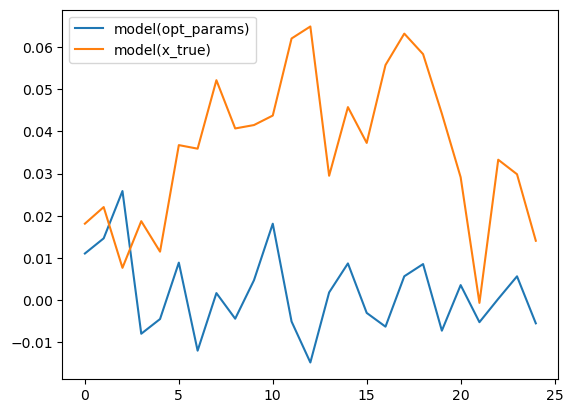

In [ ]:
plt.plot(y_observed-model_lf(optimized_params_lf))
plt.plot(y_observed-model_lf(x_true))
plt.legend(['model(opt_params)', 'model(x_true)'])

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [ ]:
scaling = 0.0025
n_iter =  26000 #55000
burnin = 1000 #5000
thin = 5
sub_sampling = 3

In [ ]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [ ]:
# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)

my_posteriors = [my_posterior_coarse, my_posterior_fine]

# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=cov, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

In [ ]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal,
                          iterations=n_iter, n_chains=1,
                            subsampling_rate = sub_sampling,
                              initial_parameters=x_true)
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )




Sampling chain 1/1


Running chain, α_c = 0.503, α_f = 0.16: 100%|██████████| 26000/26000 [12:07<00:00, 35.75it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.687
    x1       float64 8B 2.152
    x2       float64 8B 2.944
    x3       float64 8B 6.423
    x4       float64 8B 4.511
    x5       float64 8B 1.479
    ...       ...
    x58      float64 8B 1.458
    x59      float64 8B 1.346
    x60      float64 8B 3.446
    x61      float64 8B 1.474
    x62      float64 8B 1.374
    x63      float64 8B 2.786 





Let's look at the trace plot of one chain

# Diagnostics 

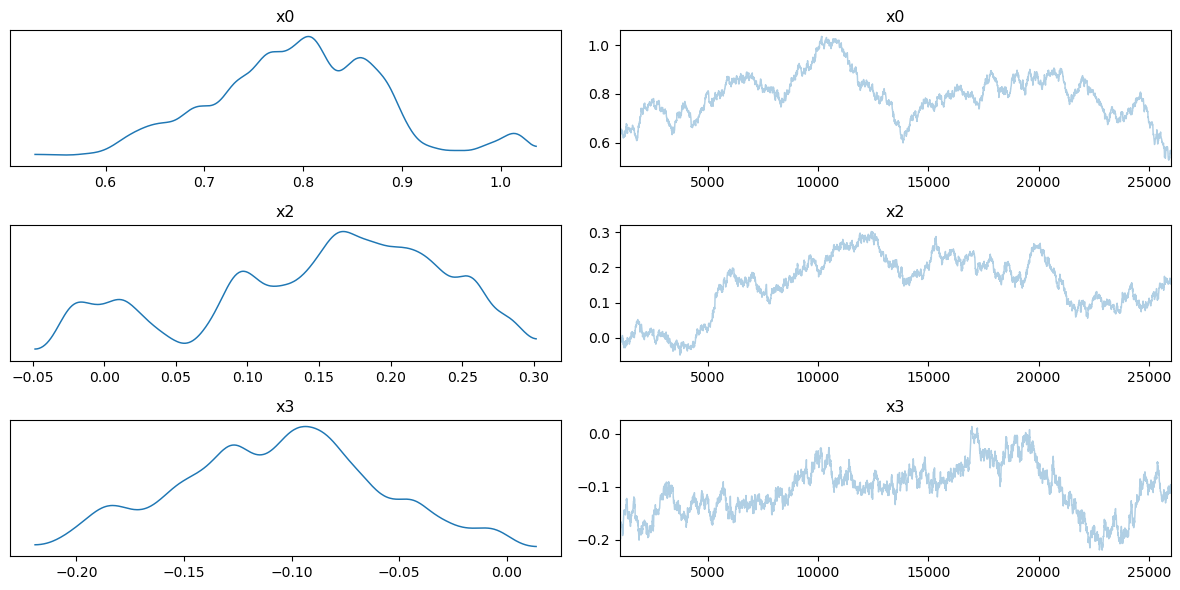

In [ ]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

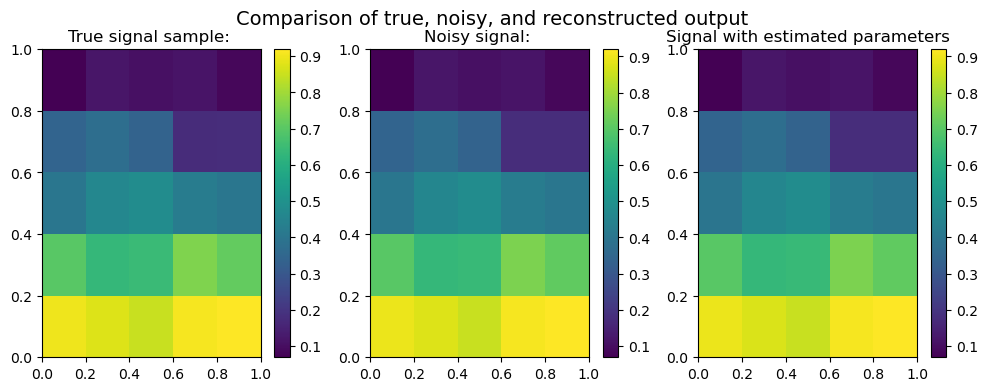

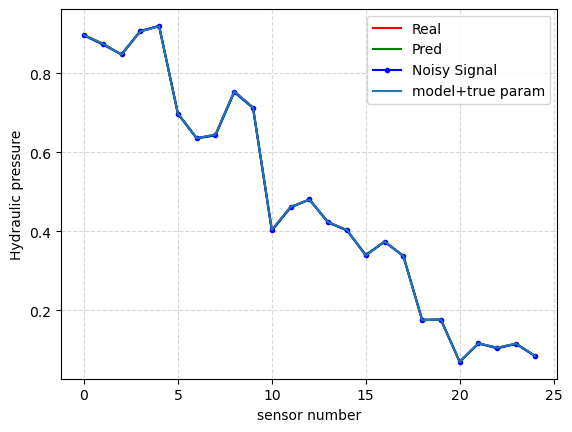

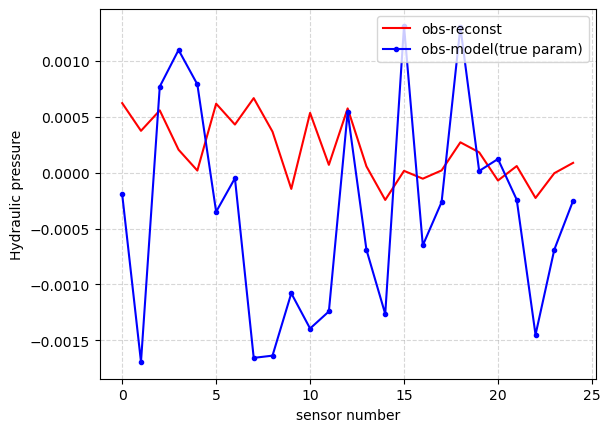

In [ ]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, n_eig, x_true)

Finally, let's look at the parameters distribution

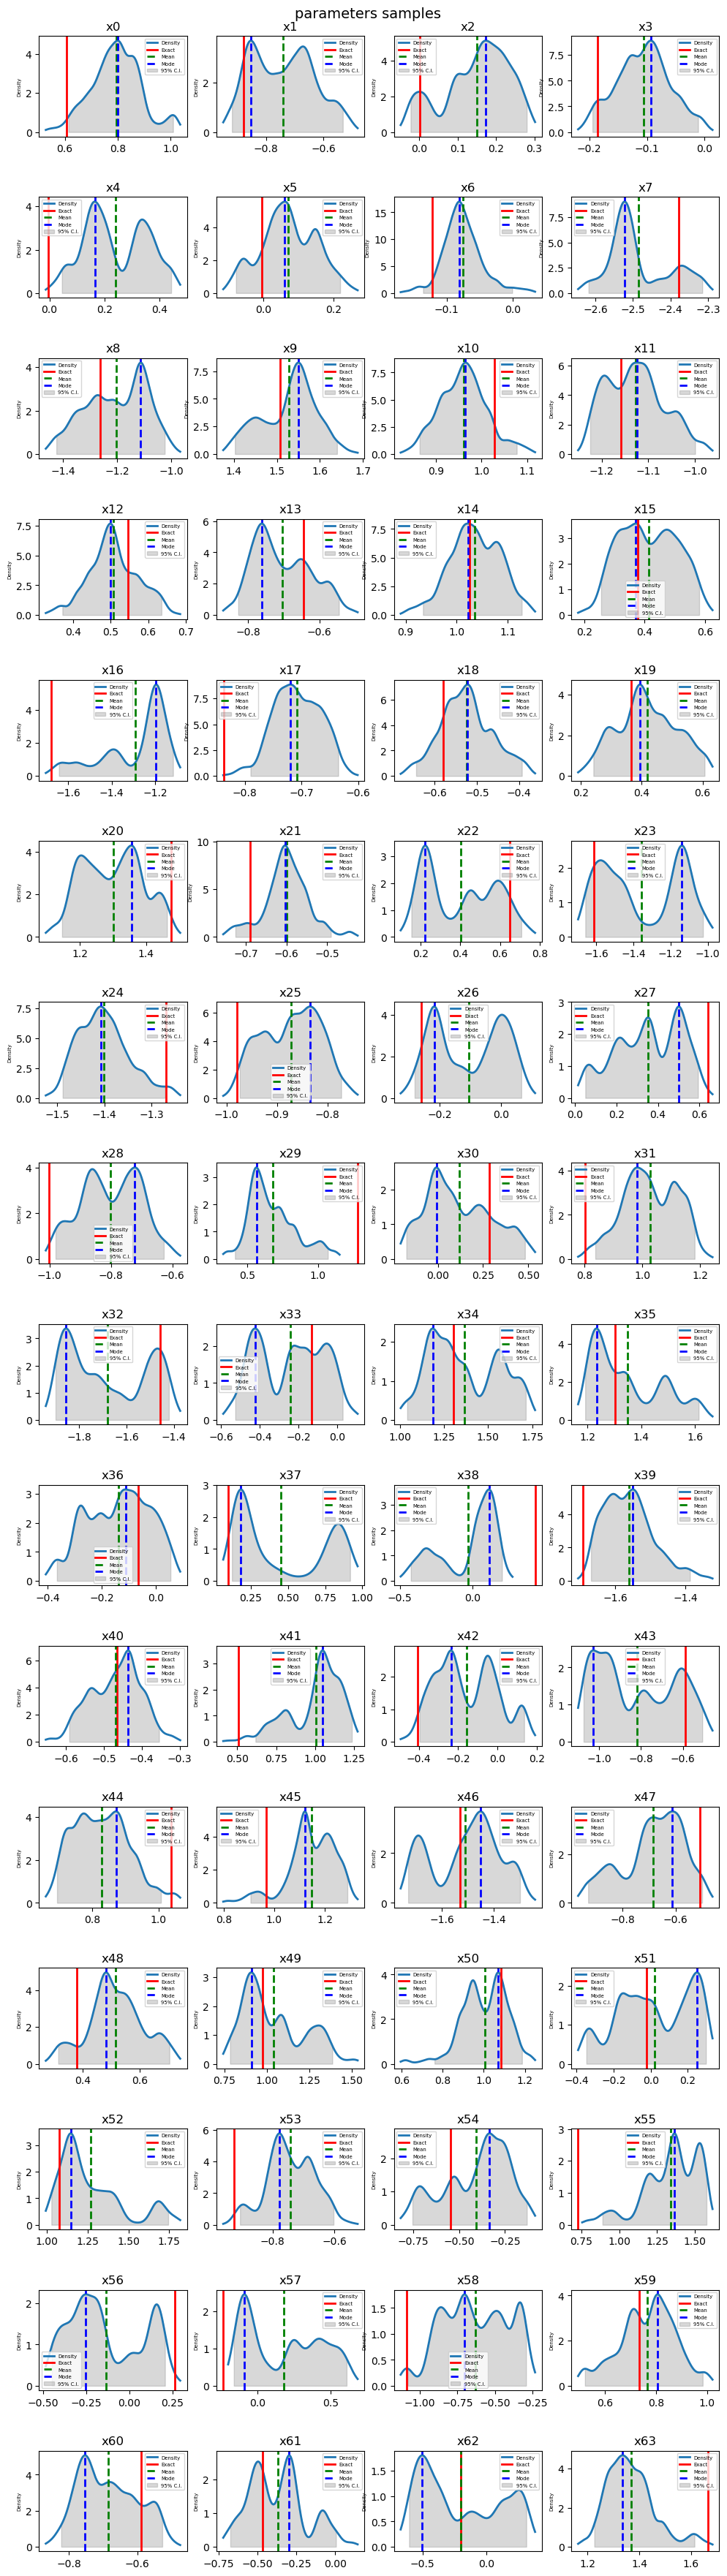

In [ ]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

Reconstructed field 

In [ ]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### Higher Noise 

In [ ]:
noise = 0.01
scaling = 0.05
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")


Sampling chain 1/1


Running chain, α_c = 0.400, α_f = 0.22: 100%|██████████| 30000/30000 [04:57<00:00, 100.88it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 10.54
    x1       float64 8B 1.455
    x2       float64 8B 1.469
    x3       float64 8B 11.35
    x4       float64 8B 2.136
    x5       float64 8B 2.154
    ...       ...
    x58      float64 8B 5.292
    x59      float64 8B 7.155
    x60      float64 8B 1.617
    x61      float64 8B 8.688
    x62      float64 8B 1.383
    x63      float64 8B 2.169 





In [ ]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

7.302906295209541

<Figure size 1000x400 with 0 Axes>

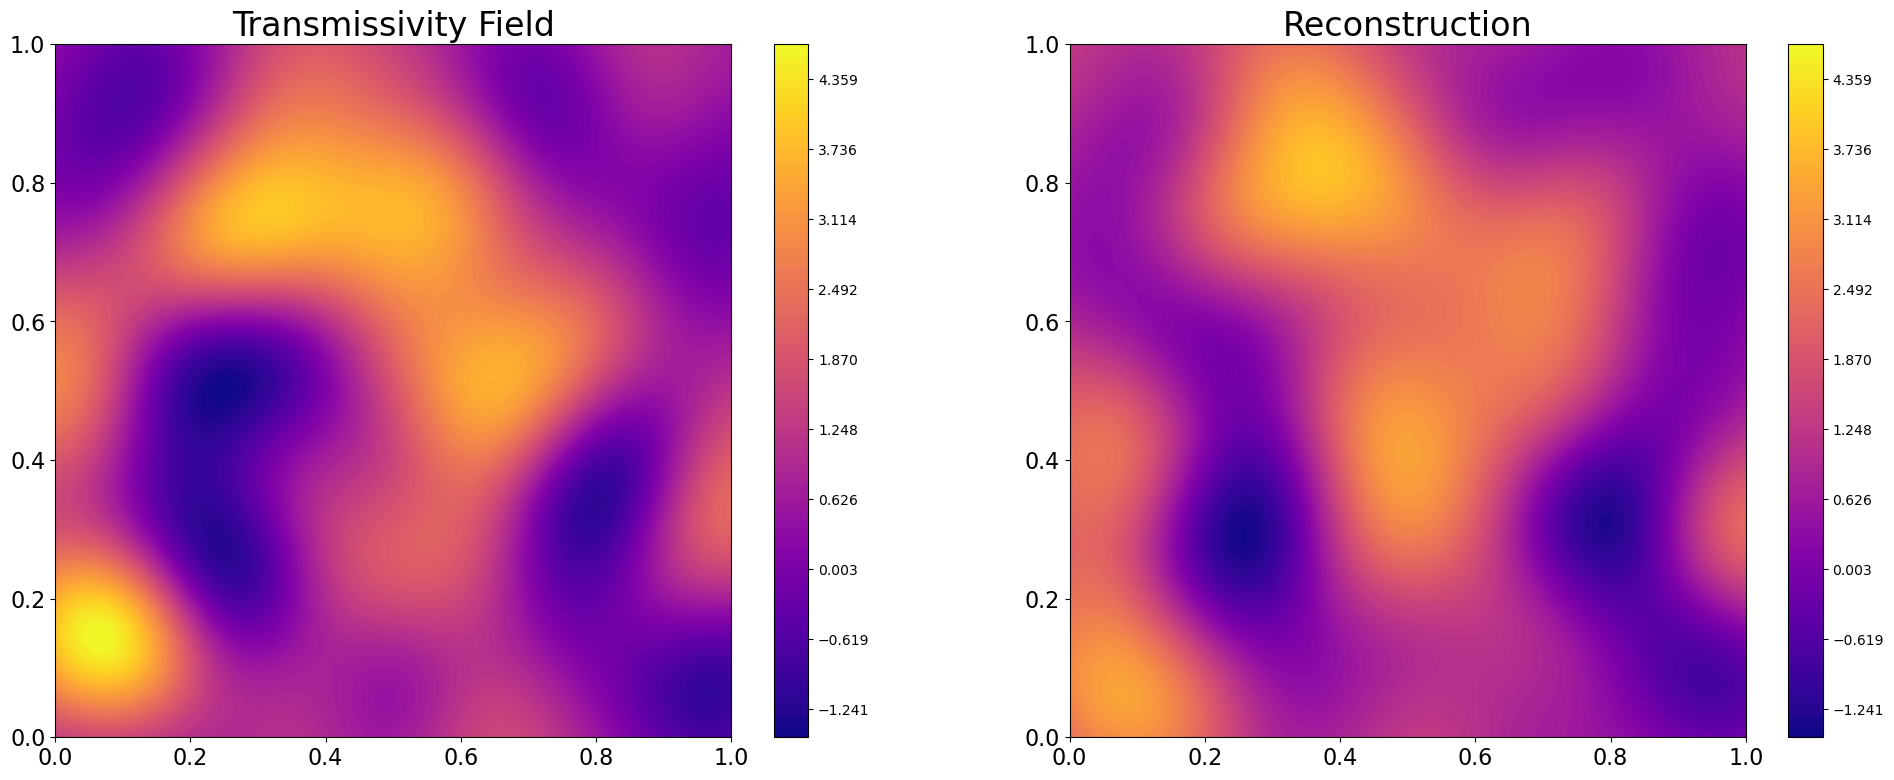

In [ ]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### Computation of Time / ESS

In [42]:
noise = 0.01
scaling = 0.05
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

ESS_values = []
times = []
# RUN THE MCMC
for i in range(3): 
    start = timeit.default_timer()
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Save executing time 
    times.append(end-start)
    ess = az.ess(idata)  
    e = [ess.data_vars['x'+str(i)].values for i in range(64)]
    ESS_values.append(np.mean(e))
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ESS_values)
print("Computing times:       ", times )
print("Average Time/ESS       ", np.mean(times)/np.mean(ESS_values))

Sampling chain 1/1


Running chain, α_c = 0.350, α_f = 0.18: 100%|██████████| 30000/30000 [04:40<00:00, 107.09it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.400, α_f = 0.22: 100%|██████████| 30000/30000 [04:44<00:00, 105.40it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.560, α_f = 0.26: 100%|██████████| 30000/30000 [04:29<00:00, 111.18it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  [8.184334270623108, 7.765975210379285, 7.373163017816922]
Computing times:        [280.2598450840014, 284.68402654199963, 269.8910218339988]
Average Time/ESS        35.79376499371014


In [43]:
np.mean(ESS_values)

7.7744908329397715

In [44]:
np.mean(times)

278.27829782